# Lab 4 - Unsupervised learning

## M1DS - Machine Learning 1

In this lab, we are going to tackle two unsupervised learning problems : clustering and dimensionality reduction, using the `scikit-learn` library, as always.

<div style=" padding: 8px;">
Report written by <b>Gwenn Garrigues</b>, <b>Danila Pechenev</b>, 16/10.
</div>

In [16]:
# Import usual librairies
import numpy as np
from matplotlib import pyplot as plt

### Exercise 1 - Clustering

First, we are going to generate some fake data in 2D (cell below).

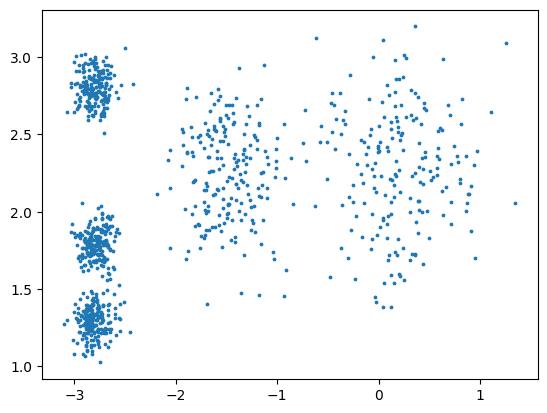

In [17]:
from sklearn.datasets import make_blobs

# Generate fake data
blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, _ = make_blobs(n_samples=1000, centers=blob_centers, cluster_std=blob_std, random_state=7)

# Visualize data
plt.scatter(X[:,0], X[:,1], s=3)
plt.show()

**Q1.** Run the K-Means algorithm with $K = 5$ (check the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)), and display on the same plot the clusters (i.e., each data point is colored depending on its cluster) and their centroids. Comment.

In [18]:
from sklearn.cluster import KMeans

def visualize_kmeans(X, n_clusters, random_state, n_init=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=n_init).fit(X)
    centroids = kmeans.cluster_centers_
    labels = kmeans.predict(X)
    
    u_labels = np.unique(labels)
    
    for i in u_labels:
        plt.scatter(X[labels == i, 0], X[labels == i, 1], label = i, s = 20)
    plt.scatter(centroids[:,0], centroids[:,1], s = 40, color = 'k')
    plt.title("Clustering results")
    plt.legend()
    plt.show()

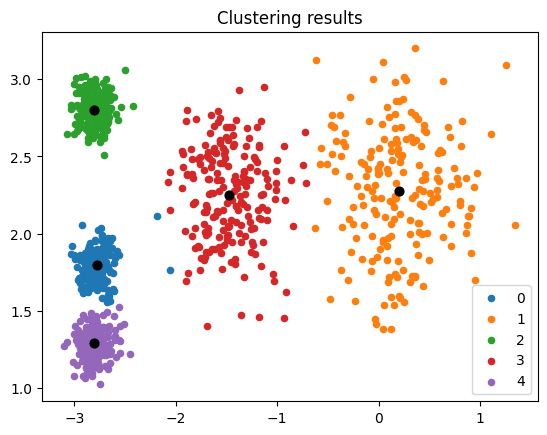

In [19]:
visualize_kmeans(X, n_clusters=5, random_state=42)

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">
We can clearly observe five well-defined clusters produced by the K-Means algorithm with k = 5 and n_init = 5.
</div>

**Q2.** Playing with the argument `random_state` (i.e., changing the seed), and setting `n_init = 1`, display two different solutions retrieved by K-Means.

Then answer the following questions :
* Why can K-Means find two different solutions ?
* Which of the two solutions should we keep ?
* What is then recommended to do when using K-Means to prevent this problem ?

Random_state = 0


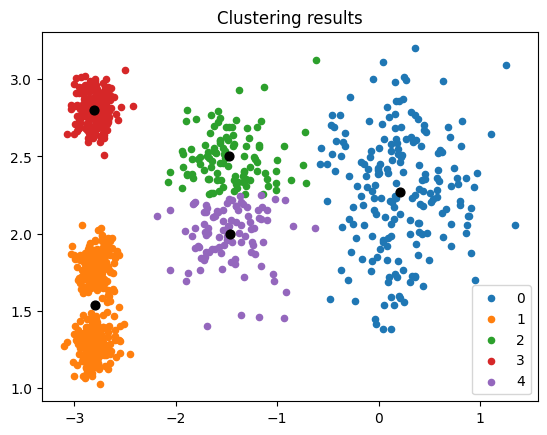


Random_state = 2


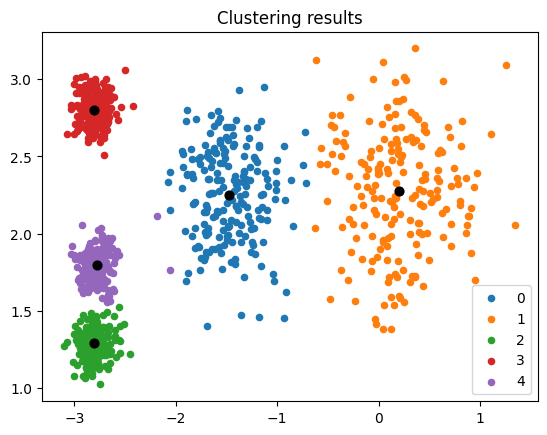

In [20]:
print("Random_state = 0")
visualize_kmeans(X, n_clusters=5, random_state=0, n_init=1)
print()
print("Random_state = 2")
visualize_kmeans(X, n_clusters=5, random_state=2, n_init=1)

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">

<li>The K-Means algorithm can produce different solutions for the same value of K, depending on the initial positions of the centroids.</li>
<li>Between these two solutions, we should keep the second one, as its results better match the clusters that are visually distinguishable.</li>
<li>It is recommended to run the K-Means algorithm multiple times and choose the solution that minimizes the intra-cluster variance.</li>
</div>

**Q3.** Display the plot corresponding to the elbow method (i.e., inertia vs. $K$). Which $K$ is optimal according to this method ? Comment.

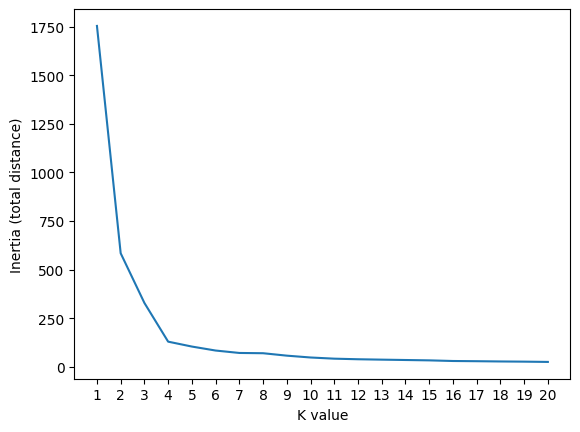

In [21]:
def cluster_variance(X, n_max, random_state=42):
    variances=[]
    outputs=[]
    k_values=list(range(1, n_max + 1))  
    
    for k in range(1, n_max + 1):
        model = KMeans(n_clusters=k, random_state=random_state).fit(X)
        variances.append(model.inertia_)
        
    return k_values, variances

k_values, variances = cluster_variance(X, n_max=20)
plt.plot(k_values, variances)
plt.ylabel("Inertia (total distance)")
plt.xlabel("K value")
plt.xticks(k_values)
plt.show()

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">
We can clearly see an "elbow" at K=4.
</div>

**Q4.** Application : image segmentation.

Run the cell code below. Explain what the code is doing, and interpret the produced figure.

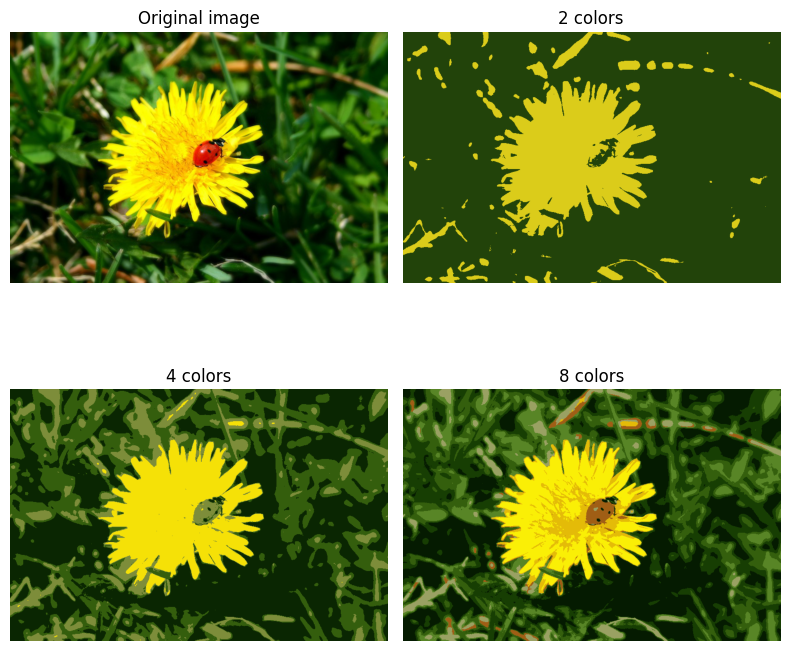

In [22]:
import PIL

image = np.asarray(PIL.Image.open('../data/ladybug.png'))
X = image.reshape(-1, 3)

segmented_imgs = []

K_list = (2, 4, 8)
for K in K_list:
    kmeans = KMeans(n_clusters=K, n_init=10, random_state=0).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

fig, ax = plt.subplots(2,2,figsize=(8,8))

ax[0,0].set_title("Original image")
ax[0,0].imshow(image)
ax[0,0].set_axis_off()

ax[0,1].set_title("2 colors")
ax[0,1].imshow(segmented_imgs[0]/255)
ax[0,1].set_axis_off()

ax[1,0].set_title("4 colors")
ax[1,0].imshow(segmented_imgs[1]/255)
ax[1,0].set_axis_off()

ax[1,1].set_title("8 colors")
ax[1,1].imshow(segmented_imgs[2]/255)
ax[1,1].set_axis_off()

plt.tight_layout()
plt.show()

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">
This code uses the K-Means algorithm to associate each pixel of the image with one of K classes for a given value of K. The value of K determines the number of colors in the resulting image. The color assigned to each cluster corresponds to the average color of the pixels within that cluster.
In more detail:
<li>Original image: the unprocessed picture.</li>
<li>K = 2: The image is represented with only two colors. Many details are lost, but the main object and the background are still distinguishable.</li>
<li>K = 4: The image is represented with four colors. We can now distinguish the flower, the ladybug, and the shades of grass in the background.</li>
<li>K = 8: The image is represented with eight colors. The resulting picture is quite close to the original.</li>
</div>

### Exercise 2 - PCA

In this exercise, we are going to use the *Olivetti* dataset, which contains black-and-white pictures of faces.

In [23]:
from sklearn.datasets import fetch_olivetti_faces

X = fetch_olivetti_faces(shuffle=True, random_state=1).data
# Centering data, which is needed for PCA
X = X - np.mean(X, axis=0)

**Q1.** How many features do we have in this example ? Display a few images from the dataset.

In [24]:
print(f"The dataset has {X.shape[0]} samples and {X.shape[1]} features")

The dataset has 400 samples and 4096 features


In [25]:
def plot_gallery(title, images, sub_title, n_col, n_row, cmap=plt.cm.gray):
    image_shape = (64, 64)
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, vec, sub in zip(axs.flat, images, sub_title):
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")
        ax.set_title(f"{sub}")
    plt.show()

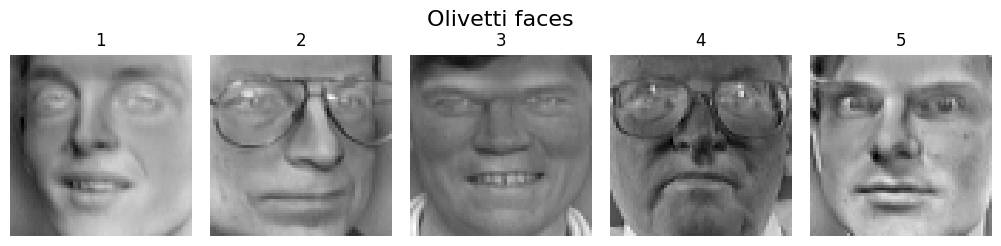

In [26]:
plot_gallery("Olivetti faces", X, [1, 2, 3, 4, 5], n_col=5, n_row=1)

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">
The dataset contains 400 samples and 4096 features. Each feature corresponds to a pixel in an image; therefore, the dataset consists of 64×64 images.
</div>

**Q2.** Applying PCA to the dataset, how many components do we need to explain 95% of the variance ?

In [27]:
from sklearn.decomposition import PCA

explained_variance_ratio = 0
n_components = 0
while explained_variance_ratio < 0.95:
    n_components += 1
    pca = PCA(n_components=n_components, random_state=42)
    pca.fit(X)
    explained_variance_ratio = sum(pca.explained_variance_ratio_)
print(n_components)

124


<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">
124 components are required to explain at least 95% of the variance
</div>

**Q3.** To reconstruct a point in its original representation, we can use the `inverse_transform` method.

Since we are working with images, after reducing the dimensionality, we will obtain an imperfect reconstruction of the original image.

Set now the number of components to 300. Select an image from the dataset, and compare it to its reconstruction.

In [28]:
IMG_INDEX=100
pca = PCA(n_components=300, random_state=42)
pca.fit(X)
inversed = pca.inverse_transform(pca.transform(X)) 

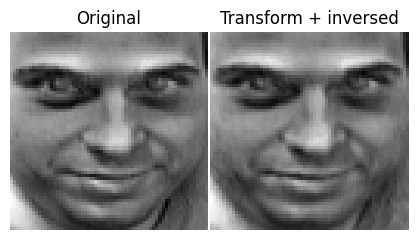

In [29]:
plot_gallery(
    title="",
    images=[X[IMG_INDEX], inversed[IMG_INDEX]],
    sub_title=["Original", "Transform + inversed"],
    n_col=2,
    n_row=1,
)

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">
We can see that the image obtained after dimensionality reduction and reconstruction is visually almost indistinguishable from the original. This is easily explained by the fact that, as shown earlier, 124 components are required to explain at least 95% of the variance; therefore, 300 components capture nearly all the variance of the original image.
</div>

**Q4.** For the same image, display in a subplot how the reconstruction evolves while keeping only 10, 20, 30... Up to 300 components.

What is the minimal number of components for which you consider the reconstruction to be acceptable ?

Conclude about the usefulness of this method.

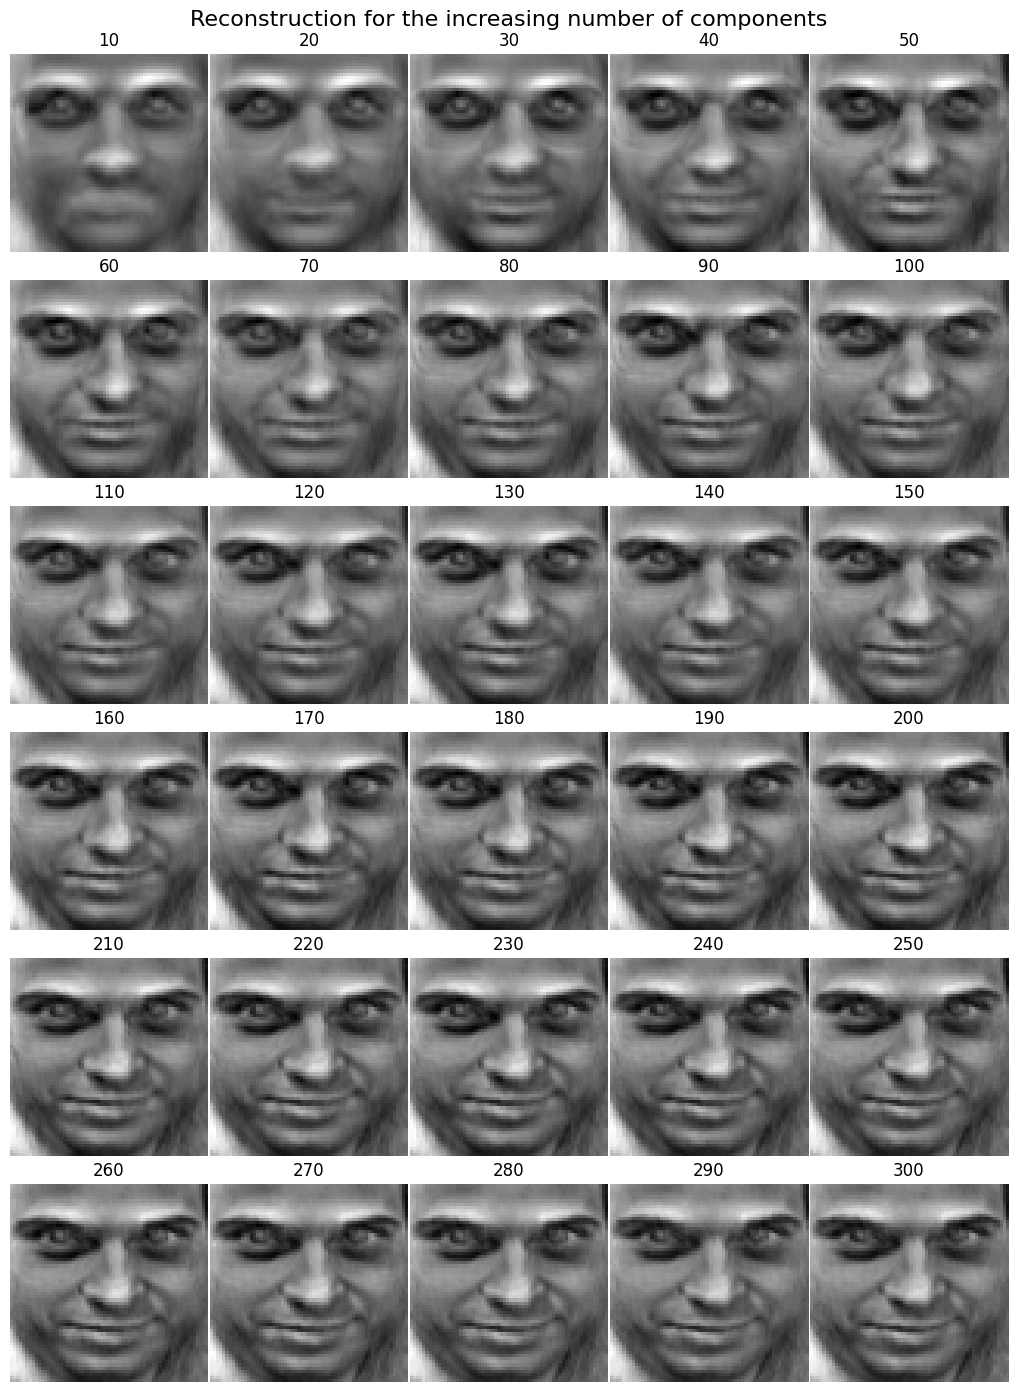

In [30]:
image_shape = (64, 64)
n_cols = 5
n_row = 6
    
images = []
components = list(range(10, 310, 10))
for n_components in components:
    pca = PCA(n_components=n_components, random_state=42)
    pca.fit(X)
    inversed = pca.inverse_transform(pca.transform(X))
    images.append(inversed[IMG_INDEX])

plot_gallery("Reconstruction for the increasing number of components", images, components, n_col=n_cols, n_row=n_row)

<div style="border: 2px solid #4CAF50; padding: 10px; border-radius: 8px; background-color:#f0fff0">
It is difficult to specify the exact number of components at which the reconstruction becomes acceptable, since this is a subjective assessment. However, by comparing the reconstructed images with the original one, we can see that starting from around 200 components, even fairly small details are preserved.

PCA method has proven to be very useful, as it allows reducing the number of features from 4096 to about 200 — more than a 20-fold decrease — without any noticeable loss in image quality. This effectively helps to mitigate the curse of dimensionality.
</div>

---

End of lab4.